# 70% Accuracy

In [ ]:
import pandas as pd
import numpy as np

import re
import string
import nltk
import spacy

import time
from pprint import pprint


# Visualization Libraries
import matplotlib.pyplot as plt
%matplotlib inline


import plotly.express as px
# import plotly.graph_objects as go
# import chart_studio.plotly as py


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.feature_extraction.text import TfidfVectorizer





stopword = nltk.corpus.stopwords.words('portuguese')
# wnl = nltk.WordNetLemmatizer()
port_lemma = spacy.load('pt_core_news_lg')

In [2]:
review_df = pd.read_csv('../../Data/raw-data/olist_order_reviews_dataset.csv')
review_df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [3]:
review_df.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

In [4]:
review_df.shape

(100000, 7)

In [5]:
review_non_na_df = review_df[review_df.review_comment_message.notna()][['review_score', 'review_comment_message']]
review_non_na_df.shape

(41753, 2)

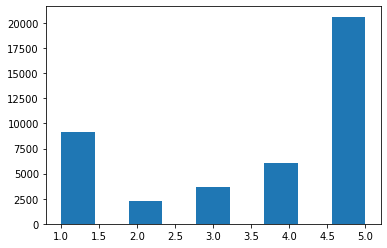

In [6]:
plt.hist(review_non_na_df.review_score, bins = 9)
plt.show()

In [7]:
review_non_na_df.loc[review_non_na_df['review_score'] == 1, 'review_score_category'] = 'low'
review_non_na_df.loc[review_non_na_df['review_score'].isin([2, 3, 4]), 'review_score_category'] = 'mid'
review_non_na_df.loc[review_non_na_df['review_score'] == 5, 'review_score_category'] = 'high'

review_non_na_df.head()

,review_score,review_comment_message,review_score_category
3,5,Recebi bem antes do prazo estipulado.,high
4,5,Parabéns lojas lannister adorei comprar pela I...,high
9,4,aparelho eficiente. no site a marca do aparelh...,mid
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",mid
15,5,"Vendedor confiável, produto ok e entrega antes...",high


In [8]:
data=review_non_na_df

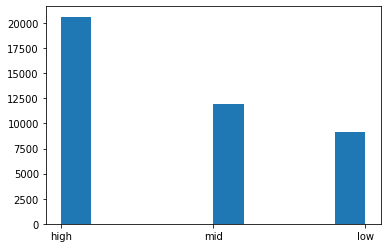

In [9]:
plt.hist(data.review_score_category)
plt.show()

In [10]:
def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

data['review_comment_msg_clean'] = data['review_comment_message'].apply(lambda x: remove_punct(x))
data.head()

,review_score,review_comment_message,review_score_category,review_comment_msg_clean
3,5,Recebi bem antes do prazo estipulado.,high,Recebi bem antes do prazo estipulado
4,5,Parabéns lojas lannister adorei comprar pela I...,high,Parabéns lojas lannister adorei comprar pela I...
9,4,aparelho eficiente. no site a marca do aparelh...,mid,aparelho eficiente no site a marca do aparelho...
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",mid,Mas um pouco travandopelo valor ta Boa\r\n
15,5,"Vendedor confiável, produto ok e entrega antes...",high,Vendedor confiável produto ok e entrega antes ...


In [11]:
data['review_comment_message_len'] = data['review_comment_message'].str.len()
data['review_comment_msg_clean_len'] = data['review_comment_msg_clean'].str.len()

data.head()

,review_score,review_comment_message,review_score_category,review_comment_msg_clean,review_comment_message_len,review_comment_msg_clean_len
3,5,Recebi bem antes do prazo estipulado.,high,Recebi bem antes do prazo estipulado,37,36
4,5,Parabéns lojas lannister adorei comprar pela I...,high,Parabéns lojas lannister adorei comprar pela I...,100,100
9,4,aparelho eficiente. no site a marca do aparelh...,mid,aparelho eficiente no site a marca do aparelho...,174,170
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",mid,Mas um pouco travandopelo valor ta Boa\r\n,45,40
15,5,"Vendedor confiável, produto ok e entrega antes...",high,Vendedor confiável produto ok e entrega antes ...,56,54


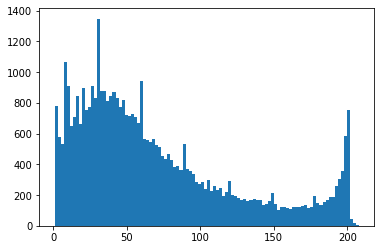

In [12]:
plt.hist(data.review_comment_message_len, bins=100)
plt.show()

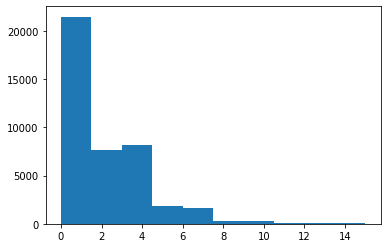

In [13]:
plt.hist(data.review_comment_message_len-data.review_comment_msg_clean_len, range=[0, 15])
plt.show()

In [14]:
data=data.drop(['review_comment_message_len', 'review_comment_msg_clean_len'], axis=1)
data.columns

Index(['review_score', 'review_comment_message', 'review_score_category',
       'review_comment_msg_clean'],
      dtype='object')

In [15]:
def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

data['review_comment_tokenized'] = data['review_comment_msg_clean'].apply(lambda x: tokenize(x.lower()))
data.head()

,review_score,review_comment_message,review_score_category,review_comment_msg_clean,review_comment_tokenized
3,5,Recebi bem antes do prazo estipulado.,high,Recebi bem antes do prazo estipulado,"[recebi, bem, antes, do, prazo, estipulado]"
4,5,Parabéns lojas lannister adorei comprar pela I...,high,Parabéns lojas lannister adorei comprar pela I...,"[parabéns, lojas, lannister, adorei, comprar, ..."
9,4,aparelho eficiente. no site a marca do aparelh...,mid,aparelho eficiente no site a marca do aparelho...,"[aparelho, eficiente, no, site, a, marca, do, ..."
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",mid,Mas um pouco travandopelo valor ta Boa\r\n,"[mas, um, pouco, travandopelo, valor, ta, boa, ]"
15,5,"Vendedor confiável, produto ok e entrega antes...",high,Vendedor confiável produto ok e entrega antes ...,"[vendedor, confiável, produto, ok, e, entrega,..."


In [17]:
def remove_stopwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stopword]
    return text

data['review_comment_nostop'] = data['review_comment_tokenized'].apply(lambda x: remove_stopwords(x))
data.head()

,review_score,review_comment_message,review_score_category,review_comment_msg_clean,review_comment_tokenized,review_comment_nostop
3,5,Recebi bem antes do prazo estipulado.,high,Recebi bem antes do prazo estipulado,"[recebi, bem, antes, do, prazo, estipulado]","[recebi, bem, antes, prazo, estipulado]"
4,5,Parabéns lojas lannister adorei comprar pela I...,high,Parabéns lojas lannister adorei comprar pela I...,"[parabéns, lojas, lannister, adorei, comprar, ...","[parabéns, lojas, lannister, adorei, comprar, ..."
9,4,aparelho eficiente. no site a marca do aparelh...,mid,aparelho eficiente no site a marca do aparelho...,"[aparelho, eficiente, no, site, a, marca, do, ...","[aparelho, eficiente, site, marca, aparelho, i..."
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",mid,Mas um pouco travandopelo valor ta Boa\r\n,"[mas, um, pouco, travandopelo, valor, ta, boa, ]","[pouco, travandopelo, valor, ta, boa, ]"
15,5,"Vendedor confiável, produto ok e entrega antes...",high,Vendedor confiável produto ok e entrega antes ...,"[vendedor, confiável, produto, ok, e, entrega,...","[vendedor, confiável, produto, ok, entrega, an..."


In [18]:
data['review_comment_tokenized_len'] = data['review_comment_tokenized'].str.len()
data['review_comment_nostop_len'] = data['review_comment_nostop'].str.len()

data.head()

,review_score,review_comment_message,review_score_category,review_comment_msg_clean,review_comment_tokenized,review_comment_nostop,review_comment_tokenized_len,review_comment_nostop_len
3,5,Recebi bem antes do prazo estipulado.,high,Recebi bem antes do prazo estipulado,"[recebi, bem, antes, do, prazo, estipulado]","[recebi, bem, antes, prazo, estipulado]",6,5
4,5,Parabéns lojas lannister adorei comprar pela I...,high,Parabéns lojas lannister adorei comprar pela I...,"[parabéns, lojas, lannister, adorei, comprar, ...","[parabéns, lojas, lannister, adorei, comprar, ...",15,12
9,4,aparelho eficiente. no site a marca do aparelh...,mid,aparelho eficiente no site a marca do aparelho...,"[aparelho, eficiente, no, site, a, marca, do, ...","[aparelho, eficiente, site, marca, aparelho, i...",30,14
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",mid,Mas um pouco travandopelo valor ta Boa\r\n,"[mas, um, pouco, travandopelo, valor, ta, boa, ]","[pouco, travandopelo, valor, ta, boa, ]",8,6
15,5,"Vendedor confiável, produto ok e entrega antes...",high,Vendedor confiável produto ok e entrega antes ...,"[vendedor, confiável, produto, ok, e, entrega,...","[vendedor, confiável, produto, ok, entrega, an...",9,7


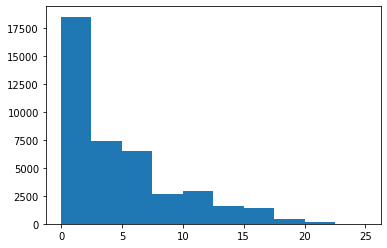

In [19]:
plt.hist(data.review_comment_tokenized_len-data.review_comment_nostop_len, range=[0, 25])
plt.show()

In [20]:
data=data.drop(['review_comment_tokenized_len', 'review_comment_nostop_len'], axis=1)
data.columns

Index(['review_score', 'review_comment_message', 'review_score_category',
       'review_comment_msg_clean', 'review_comment_tokenized',
       'review_comment_nostop'],
      dtype='object')

In [ ]:
# wnl = nltk.WordNetLemmatizer()
# port_lemma = spacy.load('pt_core_news_lg')

def clean_text(text):
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopword]
    
    ############################################################################################################
    ######################         Check if it works or not for portugese language        ######################
    ############################################################################################################
    # text = [wnl.lemmatize(word) for word in text] 
    # text = [token.lemma_ for token in port_lemma(" ".join(text))] 
    ############################################################################################################
    
    return text

data['body_text_lemmatized'] = data['review_comment_message'].apply(lambda x: clean_text(x.lower()))
data.head()


# print(clean_text("Estás bem ?"))

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/Users/shailazaman/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/queues.py", line 150, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/Users/shailazaman/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 243, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/Users/shailazaman/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/backend/reduction.py", line 236, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/Users/shailazaman/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/cloudpickle/cloudpickle.py", line 267, in dump
    return Pickler.dump(self, obj)
  File "/Users/shailazaman/opt/anaconda3/lib/python3.7/pickle.py", line 437, in dump
    self.save(obj)
  File "/Users/shailazaman/opt/anaconda3/lib/python3.7/pickle.py", line 549, in save
    s

# Check Lower Case Convertion - Portuguese

In [60]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text)), 3)*100
    # return round(count/(len(text) - text.count(" ")), 3)*100

data['punct_percentage'] = data['review_comment_message'].apply(lambda x: count_punct(x))

data.head()

,review_score,review_comment_message,review_score_category,review_comment_msg_clean,review_comment_tokenized,review_comment_nostop,body_text_lemmatized,review_comment_message_len,review_comment_msg_clean_len,punct%,punct_percentage
3,5,Recebi bem antes do prazo estipulado.,high,Recebi bem antes do prazo estipulado,"[recebi, bem, antes, do, prazo, estipulado]","[recebi, bem, antes, prazo, estipulado]","[recebi, bem, ante, prazo, estipulado]",37,36,2.7,2.7
4,5,Parabéns lojas lannister adorei comprar pela I...,high,Parabéns lojas lannister adorei comprar pela I...,"[parabéns, lojas, lannister, adorei, comprar, ...","[parabéns, lojas, lannister, adorei, comprar, ...","[parabéns, lojas, lannister, adorei, comprar, ...",100,100,0.0,0.0
9,4,aparelho eficiente. no site a marca do aparelh...,mid,aparelho eficiente no site a marca do aparelho...,"[aparelho, eficiente, no, site, a, marca, do, ...","[aparelho, eficiente, site, marca, aparelho, i...","[aparelho, eficiente, site, marca, aparelho, i...",174,170,2.3,2.3
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",mid,Mas um pouco travandopelo valor ta Boa\r\n,"[mas, um, pouco, travandopelo, valor, ta, boa, ]","[pouco, travandopelo, valor, ta, boa, ]","[pouco, travandopelo, valor, ta, boa, ]",45,40,11.1,11.1
15,5,"Vendedor confiável, produto ok e entrega antes...",high,Vendedor confiável produto ok e entrega antes ...,"[vendedor, confiável, produto, ok, e, entrega,...","[vendedor, confiável, produto, ok, entrega, an...","[vendedor, confiável, produto, ok, entrega, an...",56,54,3.6,3.6


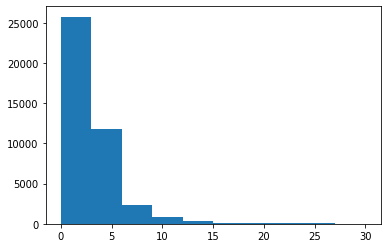

In [63]:
plt.hist(data.punct_percentage, range=[0, 30])
plt.show()

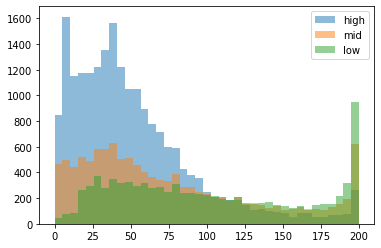

In [69]:
bins = np.linspace(0, 200, 40)

plt.hist(data[data['review_score_category']=='high']['review_comment_message_len'], bins, alpha=0.5, label='high')
plt.hist(data[data['review_score_category']=='mid']['review_comment_message_len'], bins, alpha=0.5, label='mid')
plt.hist(data[data['review_score_category']=='low']['review_comment_message_len'], bins, alpha=0.5, label='low')
plt.legend(loc='upper right')
plt.show()

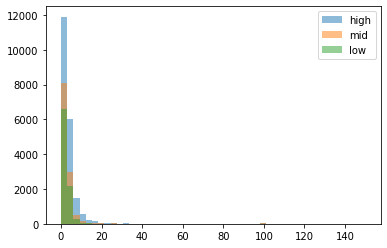

In [75]:
bins = np.linspace(0, 150, 50)

plt.hist(data[data['review_score_category']=='high']['punct_percentage'], bins, alpha=0.5, label='high')
plt.hist(data[data['review_score_category']=='mid']['punct_percentage'], bins, alpha=0.5, label='mid')
plt.hist(data[data['review_score_category']=='low']['punct_percentage'], bins, alpha=0.5, label='low')
plt.legend(loc='upper right')
plt.show()

In [31]:


tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vect.fit_transform(data['review_comment_message'])

print(X_tfidf.shape)
# print(tfidf_vect.get_feature_names())

(41753, 19680)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(data[['review_comment_message']], data['review_score_category'], test_size=0.2)

In [54]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['review_comment_message'])

tfidf_train = tfidf_vect_fit.transform(X_train['review_comment_message'])
tfidf_test = tfidf_vect_fit.transform(X_test['review_comment_message'])

X_train_vect = pd.DataFrame(tfidf_train.toarray())
X_test_vect = pd.DataFrame(tfidf_test.toarray())

X_train_vect.head()

,0,1,2,3,4,5,6,7,8,9,...,17101,17102,17103,17104,17105,17106,17107,17108,17109,17110
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)

# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [55]:
# # Number of trees in random forest
# n_estimators = [200]
# max_depth=[None]


# # Create the random grid
# random_grid = {'n_estimators': n_estimators}

# pprint(random_grid)

{'n_estimators': [200]}


In [56]:
# def compute_best_param():
#     # Use the random grid to search for best hyperparameters
#     # First create the base model to tune
#     rf = RandomForestRegressor()
    
#     # Random search of parameters, using 5 fold cross validation, 
#     # Search across 100 different combinations, and use all available cores
#     rf_random = RandomizedSearchCV(estimator = rf, 
#                                    param_distributions = random_grid,
#                                    n_jobs = -1)
    
#     # Fit the random search model
#     rf_random.fit(X_train_vect, y_train)
#     # rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

#     return str(rf_random.best_params_)


# compute_best_param()

/Users/shailazaman/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/shailazaman/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning:

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.



TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

### After lemmatizing --> 23k to 17k

In [57]:
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

start = time.time()
rf_model = rf.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = rf_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred)
# print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
#     round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

In [58]:
print(str(round((y_pred==y_test).sum()/len(y_pred), 3)*100) + '%')

70.8%


In [82]:
precision

array([0.77060783, 0.64794922, 0.55170113])

In [83]:
recall

array([0.88121876, 0.76440092, 0.34258492])

In [84]:
fscore

array([0.82220988, 0.70137421, 0.42269359])

In [85]:
train_support

array([4201, 1736, 2414])

In [89]:
y_pred, y_test

(array(['high', 'high', 'high', ..., 'mid', 'low', 'high'], dtype=object),
 71727    high
 56678    high
 86934    high
 61974    high
 30525    high
          ... 
 1781      mid
 36431    high
 89266     mid
 48376     low
 94740    high
 Name: review_score_category, Length: 8351, dtype: object)

In [90]:
result_df = pd.DataFrame(list(zip(y_pred, y_test, y_pred==y_test)), columns =['Prediction', 'Actual', 'isAccurate']) 
result_df

,Prediction,Actual,isAccurate
0,high,high,True
1,high,high,True
2,high,high,True
3,high,high,True
4,high,high,True
...,...,...,...
8346,low,mid,False
8347,high,high,True
8348,mid,mid,True
8349,low,low,True


In [91]:
result_df.to_csv('../../Data/curated-data/nlp_result.csv')